# Mock Adult dataset by CTAB-GAN+
### ***Introduction***
CTAB-GAN+ is a conditional GAN based tabular data generator. CTAB-GAN+ advances beyond SOTA methods by improving performance on regression datasets and allowing control over the quality of synthesized data. The core features ofCTAB-GAN+ include as follows:    
- (1) introduction of the auxiliary component, i.e., classifier or regressor, into conditional GAN;    
- (2) effective data encodings for mixed and simple Guassian variables;    
- (3) a novel construction of conditional vectors;    
- (4) tailored DP discriminator for tabular GAN.          

| Adult dataset was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html   
| Donor: Ronny Kohavi and Barry Becker,    
| 48842 instances, mix of continuous and discrete (train=32561, test=16281)    
| 45222 if instances with unknown values are removed (train=30162, test=15060)    
| Duplicate or conflicting instances : 6    
| Class probabilities for adult.all file    
| Probability for the label '>50K' : 23.93% / 24.78% (without unknowns)    
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)    
|     
| Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions:((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))   
|    
| Prediction task is to determine whether a person makes over 50K a year.   
|   
| Conversion of original data as follows:   
| 1. Discretized agrossincome into two ranges with threshold 50,000.   
| 2. Convert U.S. to US to avoid periods.   
| 3. Convert Unknown to "?"   
| 4. Run MLC++ GenCVFiles to generate data,test.                 
### ***Our work***   
We use CTAB-GAN+ to simulate Adult data and visualize real and fake data. See code, comments, and diagrams for details.             
### ***Reference:***
[1] B. Becker and R. Kohavi (1996). Adult [Dataset]. UCI Machine Learning Repository. Available: https://archive.ics.uci.edu/dataset/2/adult      
[2] Z. Zhao, A. Kunar, R. Birke, H. Van der Scheer, and L. Y. Chen, “CTAB-GAN+: Enhancing Tabular Data Synthesis,” Frontiers in big Data, vol. 6, p. 1296508, 2024.   

***Time ： 2024/11/26 13:42***  
***Author ： Chuang Liu***  
***Email ：LIUC0316@126.COM***  
***File ：Adult_Mocking_Plus.ipynb***  
***Notebook ：Jupyter***   

In [1]:
# Importing the model
from model.ctabgan import CTABGAN
# Importing the evaluation metrics
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
# Importing standard libraries
import numpy as np
import pandas as pd
import glob

In [2]:
# Specifying the replication number 
num_exp = 1 
# Specifying the name of the dataset used 
dataset = "Adult" 
# Specifying the path of the dataset used 
real_path = "Real_Datasets/Adult/Adult.csv" 
# Specifying the root directory for storing generated data
fake_file_root = "Fake_Datasets" 

In [3]:
# Initializing the synthesizer object and specifying input parameters
# Notice: If you have continuous variable, you do not need to explicitly assign it. It will be treated like
# that by default
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,
                 categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income'],
                 log_columns = [],
                 mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
                 general_columns = ["age"],
                 non_categorical_columns = [],
                 integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
                 problem_type= {"Classification": 'income'})

# Fitting the synthesizer to the training dataset and generating synthetic data
for i in range(num_exp):
    synthesizer.fit()
    syn = synthesizer.generate_samples()
    syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

100%|████████████████████████████████████████████████████████████████████████████| 150/150 [16:31:00<00:00, 396.41s/it]


Finished training in 59475.53351664543  seconds.


In [4]:
# Collecting the paths to all corresponding generated datasets for evaluation
fake_paths = glob.glob(fake_file_root+"/"+dataset+"/"+"*")

In [6]:
# Specifying the list of classifiers to conduct ML utility evaluation
model_dict =  {"Classification":["lr","dt","rf","mlp","svm"]}
result_mat = get_utility_metrics(real_path,fake_paths,"MinMax",model_dict, test_ratio = 0.20)

# Storing and presenting the results as a dataframe
result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = list(model_dict.values())[0]
result_df

,Acc,AUC,F1_Score
lr,2.221312,0.076398,0.063604
dt,7.278125,0.075835,0.083442
rf,2.835500,0.021003,0.049369
mlp,2.743372,0.021287,0.026333
svm,0.634661,0.008705,-0.038715


In [7]:
# Specifying the categorical columns of the dataset used
adult_categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']

# Storing and presenting the results as a dataframe
stat_res_avg = []
for fake_path in fake_paths:
    stat_res = stat_sim(real_path,fake_path,adult_categorical)
    stat_res_avg.append(stat_res)

stat_columns = ["Average WD (Continuous Columns","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res_avg).mean(axis=0).reshape(1,3),columns=stat_columns)
stat_results

column:  age WD:  0.040911903240698405
column:  workclass JSD:  0.09589702359112005
column:  fnlwgt WD:  0.0032975870970577826
column:  education JSD:  0.08195087247086807
column:  marital-status JSD:  0.25304576121554423
column:  occupation JSD:  0.2548417434585203
column:  relationship JSD:  0.3950285675095946
column:  race JSD:  0.04184469071281929
column:  sex WD:  0.5855933329879089
column:  capital-gain WD:  0.005253614224852788
column:  capital-loss WD:  0.0068647685727434545
column:  hours-per-week WD:  0.04088234532173297
column:  native-country JSD:  0.10215095586908292
column:  income JSD:  0.13310418642595373


,Average WD (Continuous Columns,Average JSD (Categorical Columns),Correlation Distance
0,0.113801,0.169733,0.647925


In [8]:
# Storing and presenting the results as a dataframe
priv_res_avg = []
for fake_path in fake_paths:
    priv_res = privacy_metrics(real_path,fake_path)
    priv_res_avg.append(priv_res)

privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res_avg).mean(axis=0).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,1.2417,0.209662,0.197312,0.827759,0.410068,0.469081


In [9]:
# Storing generated data for future use if needed
# syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

In [10]:
from table_evaluator import TableEvaluator

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  int64  
 1   workclass       48842 non-null  float64
 2   fnlwgt          48842 non-null  int64  
 3   education       48842 non-null  float64
 4   marital-status  48842 non-null  float64
 5   occupation      48842 non-null  float64
 6   relationship    48842 non-null  float64
 7   race            48842 non-null  float64
 8   sex             48842 non-null  float64
 9   capital-gain    48842 non-null  int64  
 10  capital-loss    48842 non-null  int64  
 11  hours-per-week  48842 non-null  int64  
 12  native-country  48842 non-null  float64
 13  income          48842 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 5.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column 

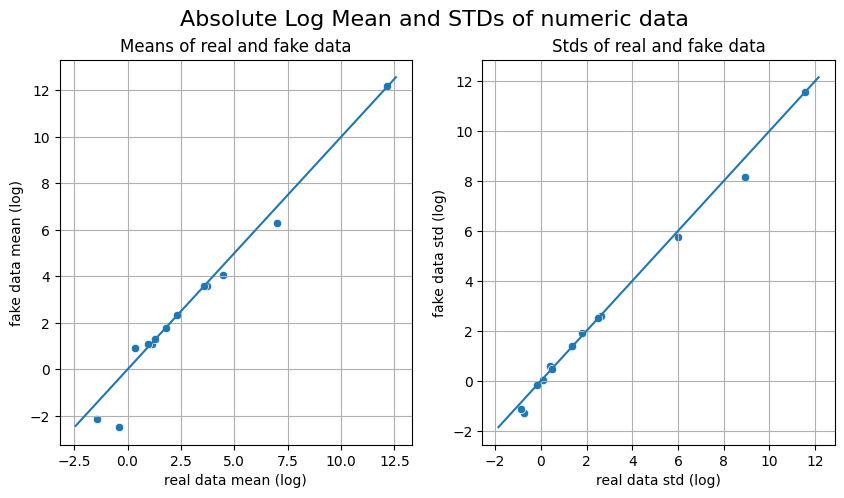

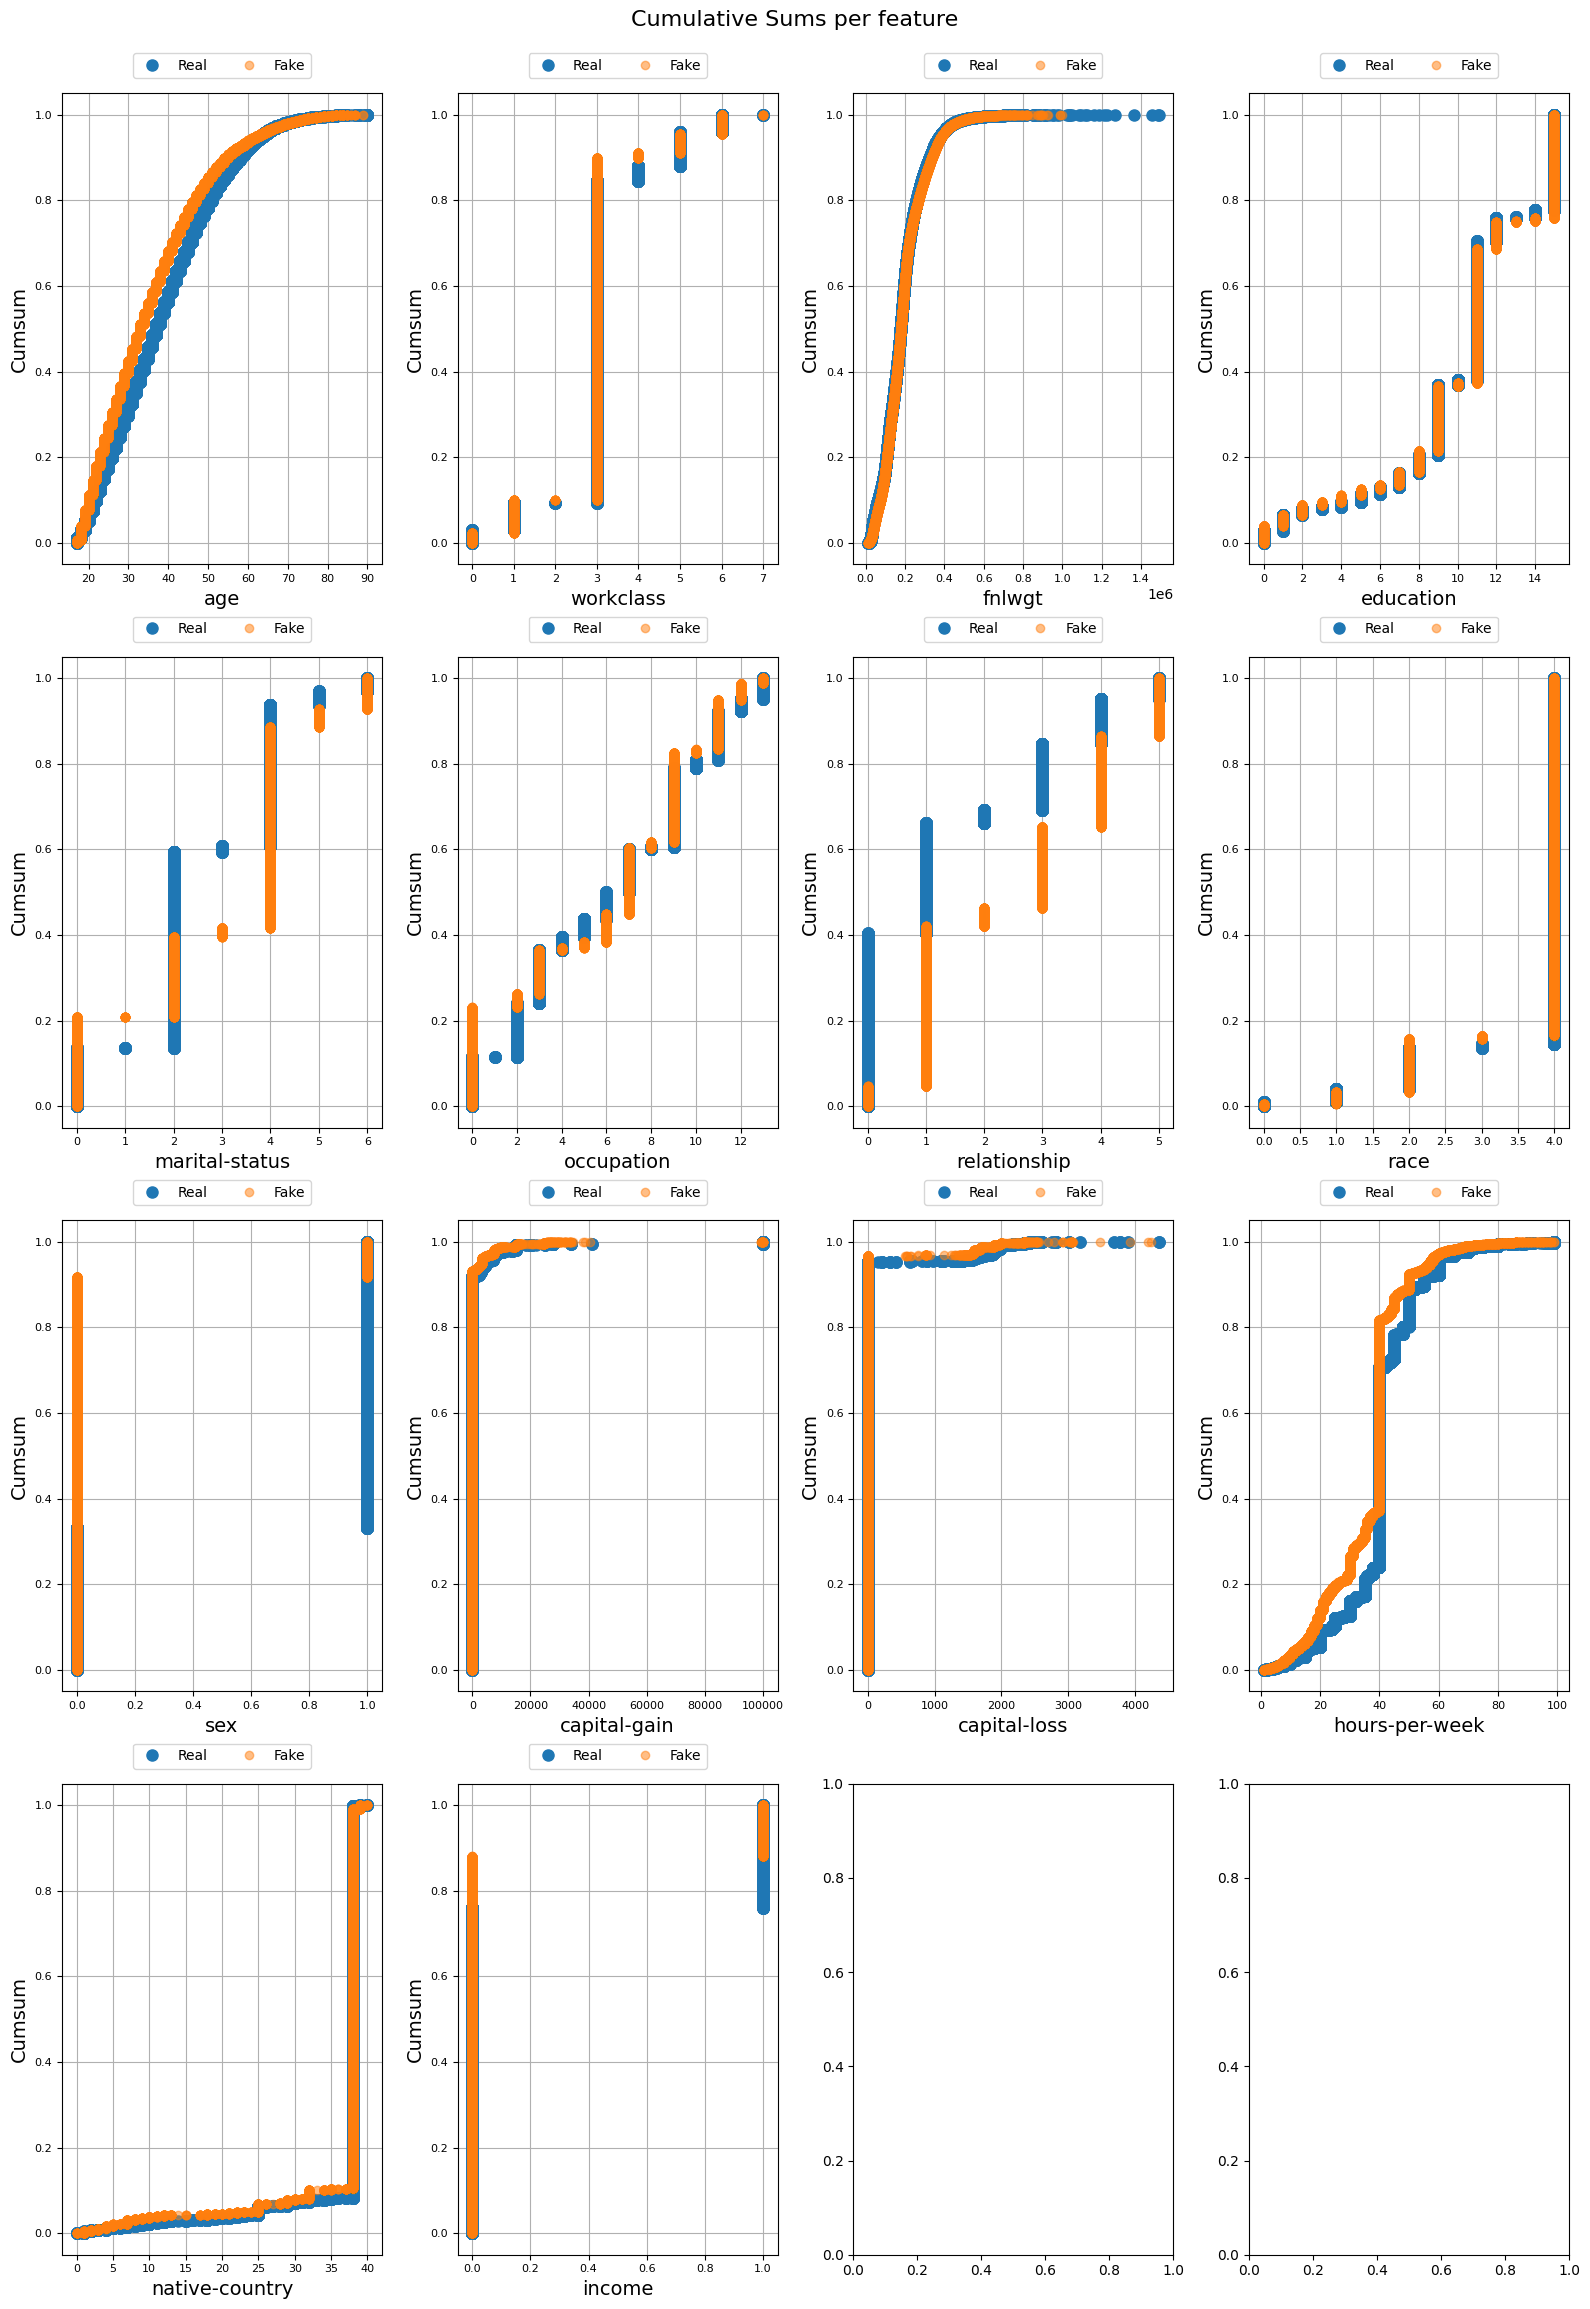

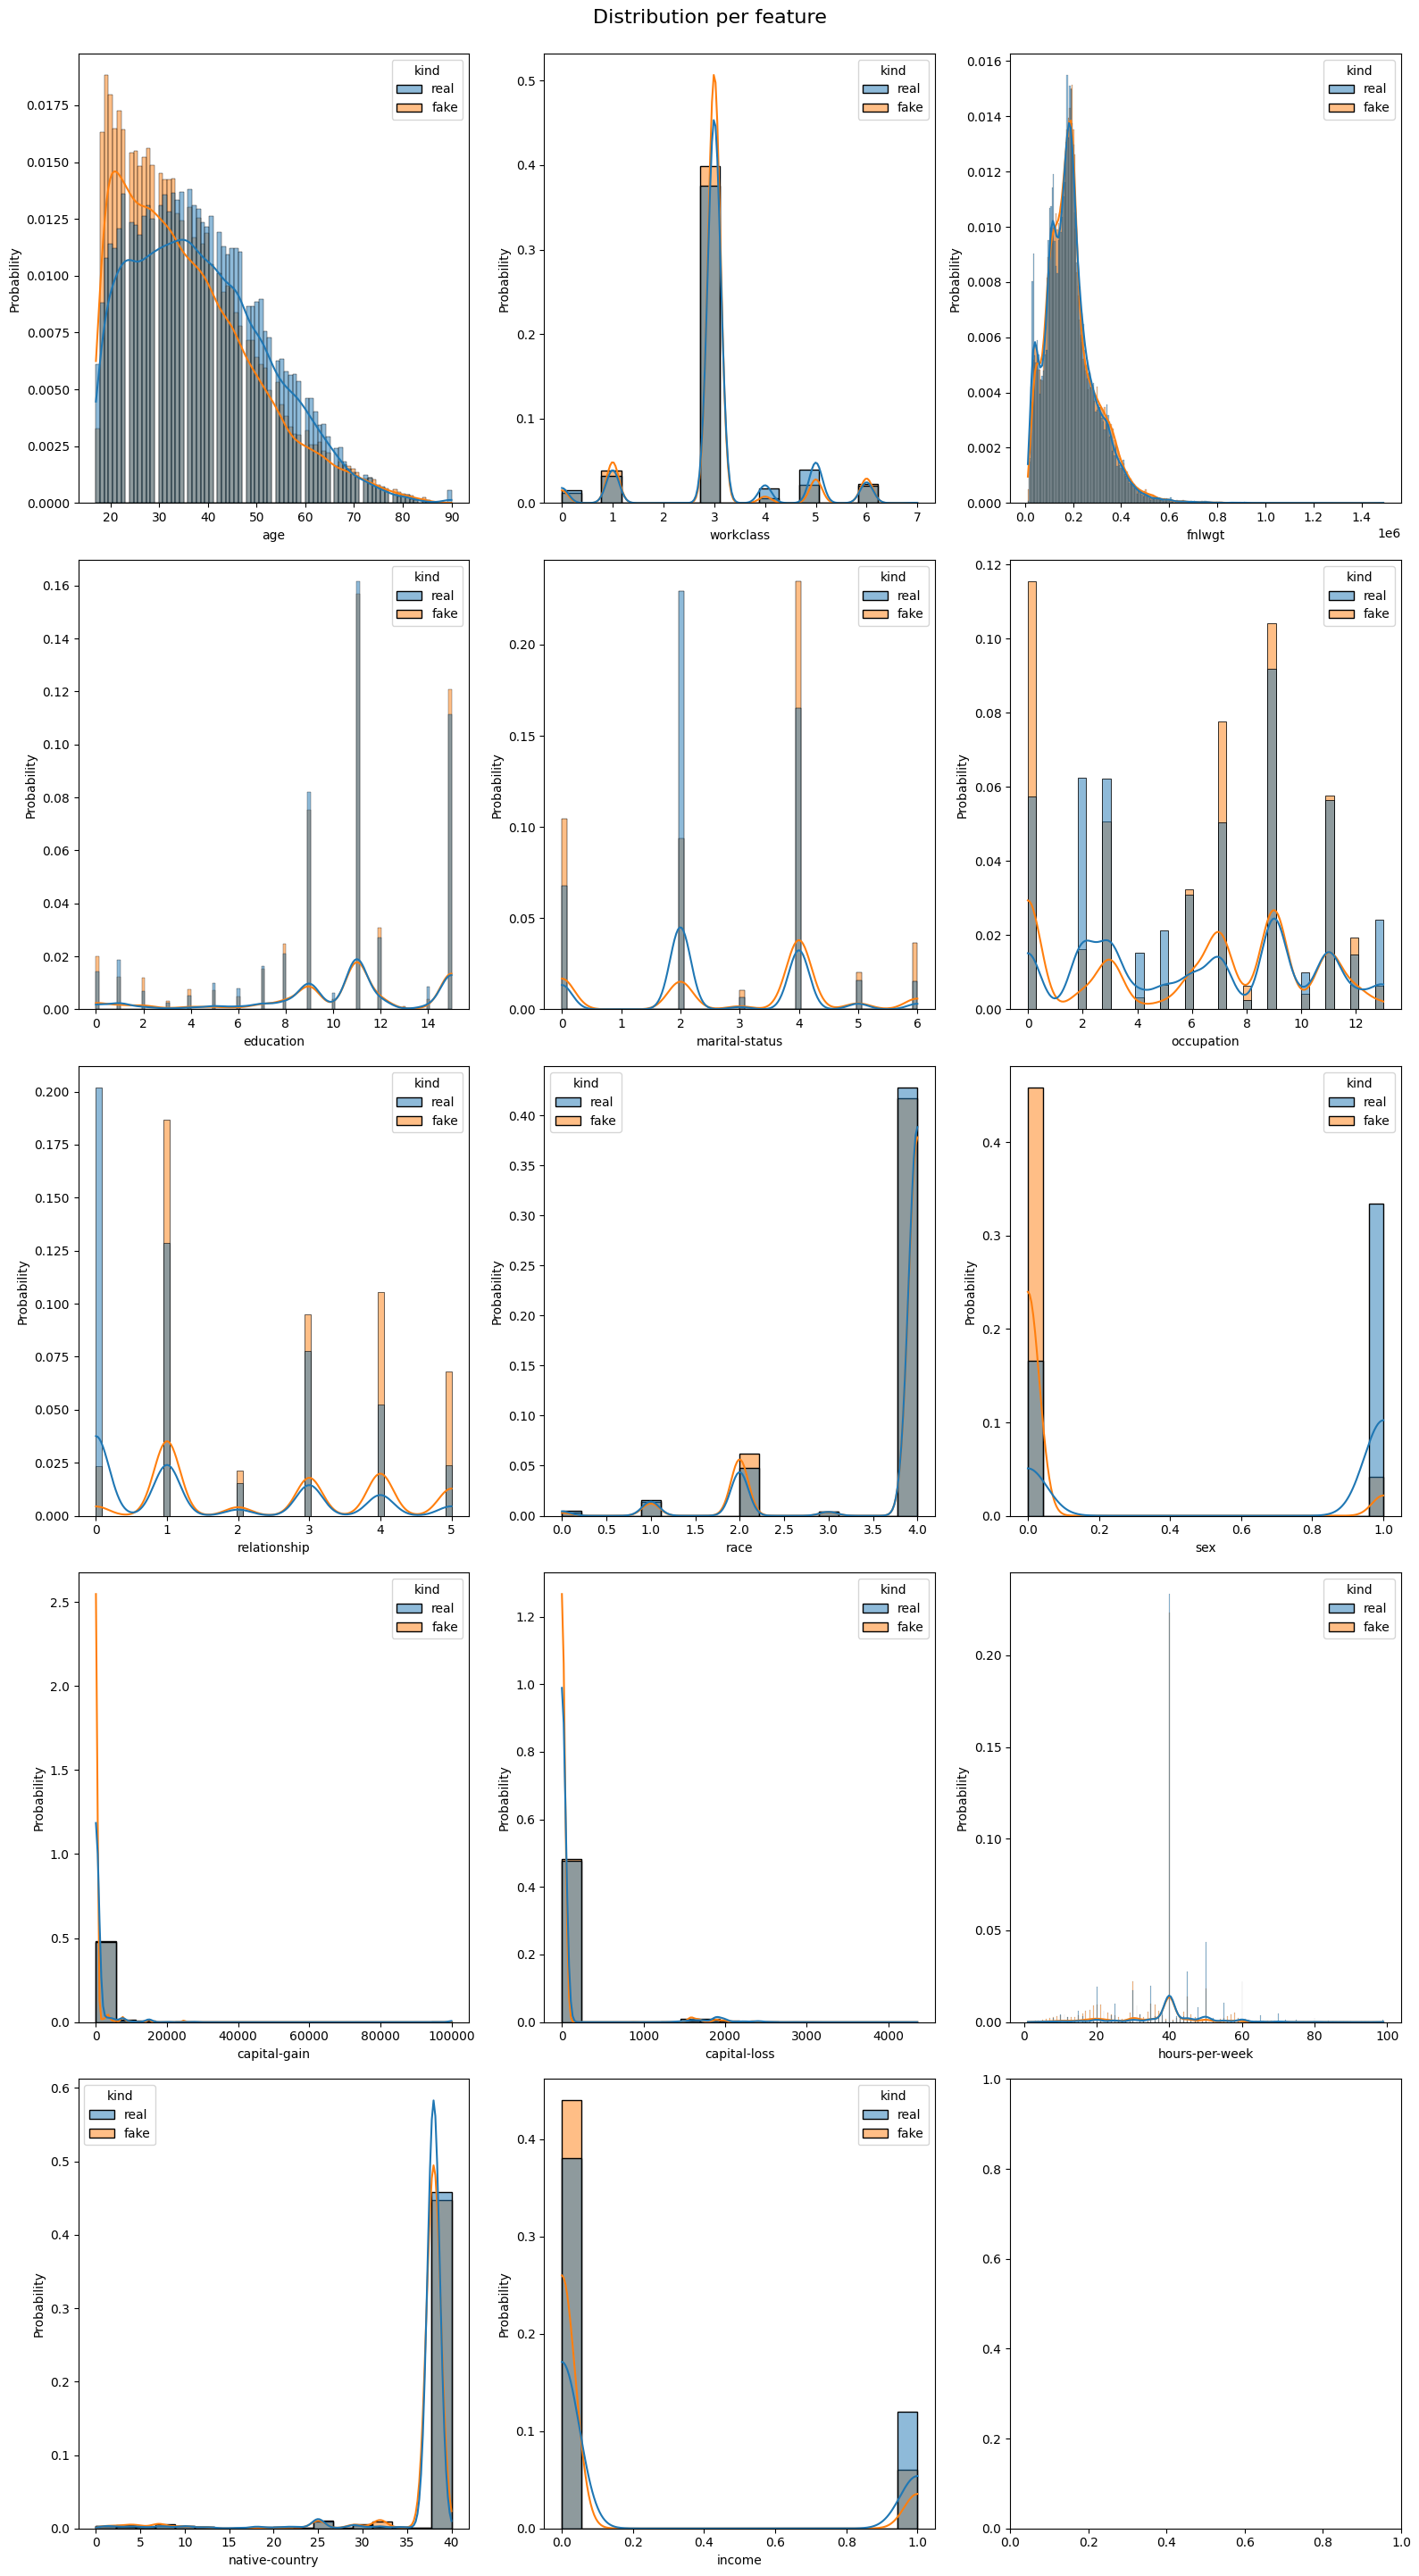

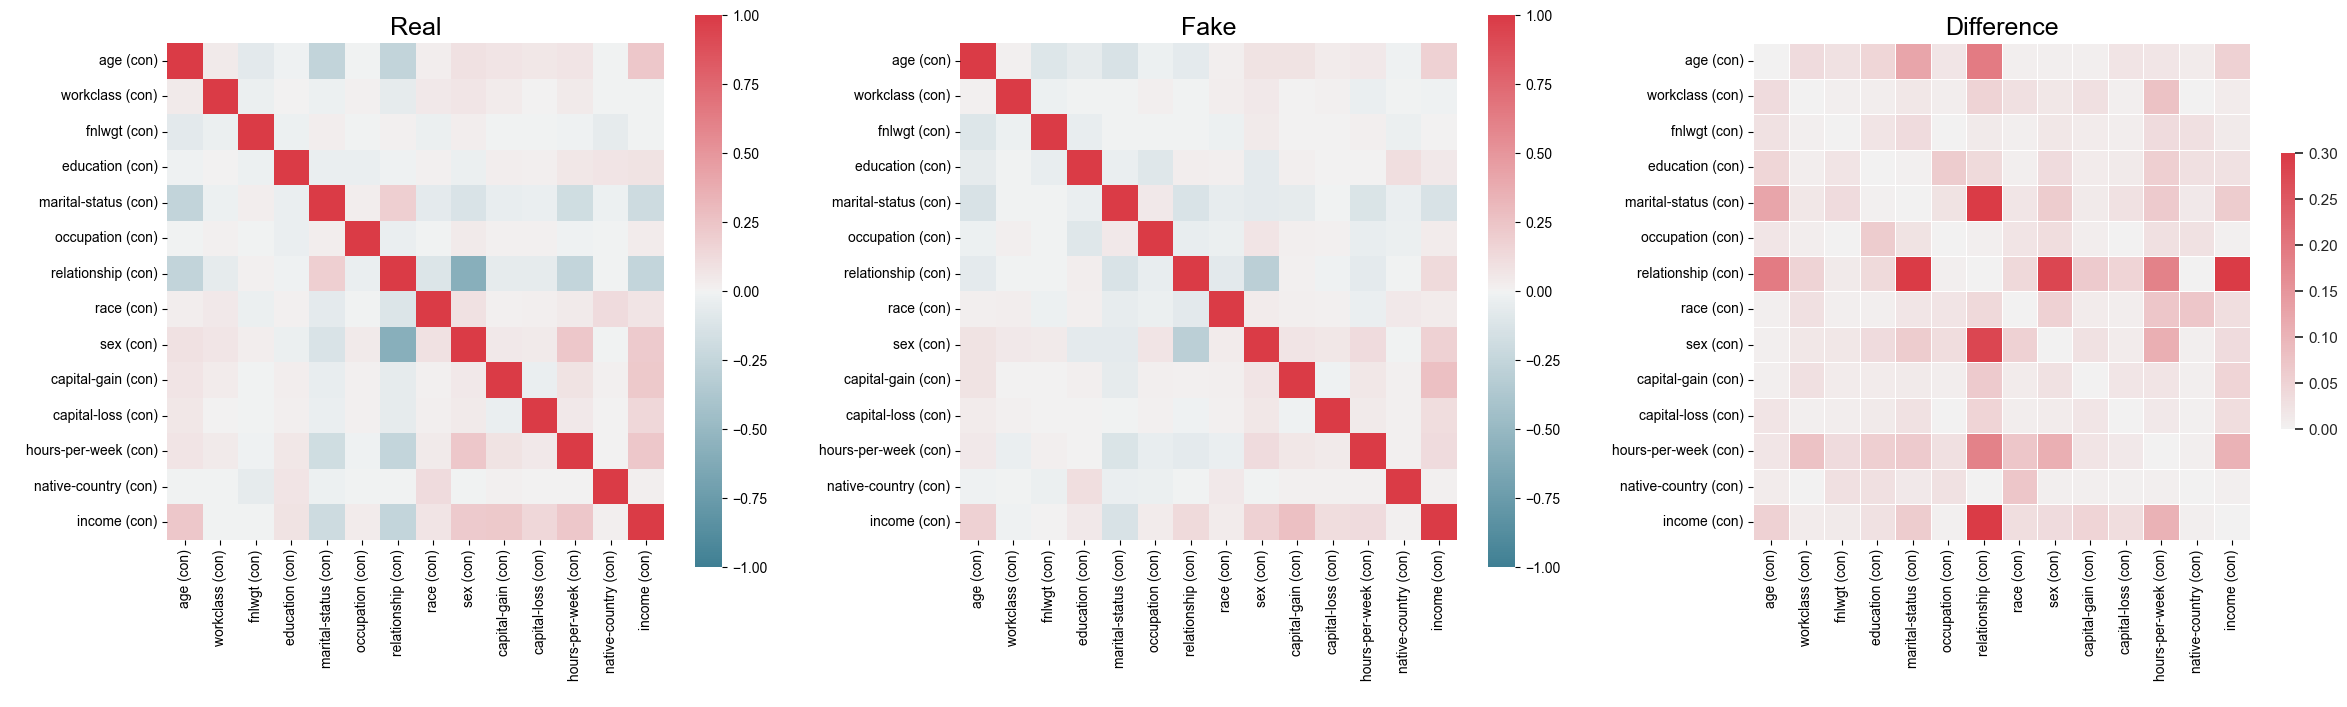

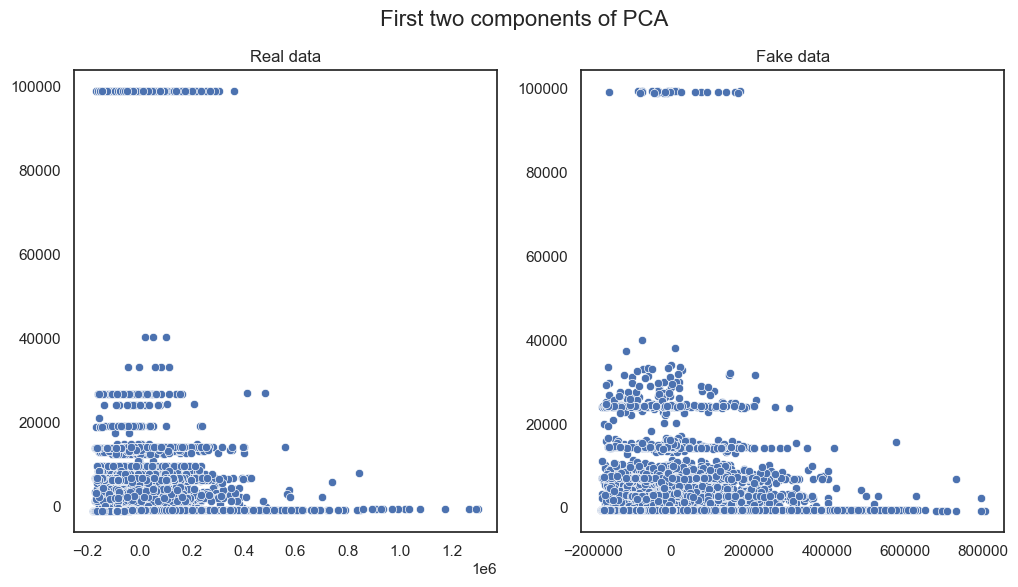

In [11]:
!pip install scipy==1.11.4
Real_Dataset = pd.read_csv('Real_Datasets/Adult/Adult.csv')
Fake_Dataset = pd.read_csv('Fake_Datasets/Adult/Adult_fake_0.csv')

Real_Dataset.head()
Real_Dataset.info()
Fake_Dataset.head()
Fake_Dataset.info()

print(Real_Dataset.shape, Fake_Dataset.shape)
table_evaluator = TableEvaluator(Real_Dataset, Fake_Dataset)

table_evaluator.visual_evaluation()